In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

### set environment variables

In [2]:
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["OPENWEATHERMAP_API_KEY"] = os.getenv("OPENWEATHERMAP_API_KEY")
os.environ["ALPHAVANTAGE_API_KEY"] = os.getenv("ALPHAVANTAGE_API_KEY")

### Import required libraries

In [3]:
from langchain.tools import tool
import os
# from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState,StateGraph, END, START
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display
import yfinance as yf
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
import re
from langchain_groq import ChatGroq
import pyowm
import requests
from bs4 import BeautifulSoup
from datetime import datetime
from langchain_community.utilities.alpha_vantage import AlphaVantageAPIWrapper
from langgraph.checkpoint.memory import MemorySaver


### Set LLM model

In [4]:

llm = ChatGroq(
    model="deepseek-r1-distill-llama-70b",
    temperature=0
)


In [5]:

chat_llm = ChatGroq(model="llama-3.1-8b-instant")

### Attraction and Activity Manager class

In [6]:
class AttractionActivityManager:
    
    def search_attraction_and_activities(self, destination):
        
        parser = StrOutputParser()
        template = """
        You are a travel expert. Provide helpful, accurate, realistic, and up-to-date information for tourists.

        Your response should follow this format:

        -------------------------------------------------------------------------------------------
        Top Attractions and Activities

        Attractions

        [Attraction Name]
        Description: [Brief description]
        Cost: [Cost per person in USD]
        Hours: [Hours of operation]

        [Repeat for minimum 10 attractions]

        Restaurants

        [Restaurant Name]
        Cuisine: [Type of cuisine]
        Cost: [Cost per person in USD]
        Hours: [Hours of operation]

        [Repeat for minimum 10 restaurants]

        Activities

        [Activity Name]
        Description: [Brief description]
        Cost: [Cost per person in USD]
        Duration: [Duration]

        [Repeat for minimum 10 activities]

        Transportation

        [Option Name]
        Description: [Brief description]
        Cost: [Cost per person or per ride in USD]
        Recommendation: [Additional helpful information]

        -------------------------------------------------------------------------------------------
        Consider the following context:
        - Desired destination: {destination}

        Fill in the details with realistic, up-to-date information for the specified destination.

        Make sure your response sticks closely to the format described above.
        
        All the cost should be given in USD

        """
        
        prompt = PromptTemplate(
            template=template,
            input_variable=[ "destination"]
        )
        
        chain = prompt | chat_llm | parser
        response = chain.invoke({"destination":destination})
        
        # Remove <think>...</think> tags and their content from LLM response.
        # return re.sub(r'<think>.*?</think>', '', response, flags=re.MULTILINE | re.DOTALL)
        return response


### Weather services

In [7]:
class WeatherService:
    
    def __init__(self, api_key=None):
        self.api_key = api_key or os.getenv("OPENWEATHERMAP_API_KEY")
        self.owm = pyowm.OWM(self.api_key)
        self.mgr = self.owm.weather_manager()

    def _get_manager(self):
        """Helper to reuse the Weather Manager instance."""
        return self.mgr


    def get_current_weather(self, city: str) -> str:
        
        try:
            observation = self.mgr.weather_at_place(city)
            weather = observation.weather

            return f"""Location: {observation.location.name}
            Temperature: {weather.temperature('celsius')['temp']}°C
            Status: {weather.status}
            Humidity: {weather.humidity}%
            Wind Speed: {weather.wind()['speed']} m/s
            """
        except Exception as e:
            return f"Error retrieving current weather for {city}. Exception: {e}"

    
    def get_weather_forecast(self, city: str) -> str:
        try:
            forecast = self.mgr.forecast_at_place(city, interval='3h')
            forecast_report = ""

            for weather_data in forecast.forecast:
                forecast_report += f"Time: {weather_data.reference_time('iso')}\n"
                forecast_report += f"Temperature: {weather_data.temperature('celsius')['temp']}°C\n"
                forecast_report += f"Status: {weather_data.status}\n"
                forecast_report += "---\n"

            return forecast_report
        except Exception as e:
            return f"Error retrieving forecast for {city}. Exception: {e}"



### Hotel booking and accomodation calculator

In [8]:
class BookingScraper:
    def __init__(self):
        # Headers to mimic a browser and enforce US English
        self.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
            'Accept-Language': 'en-US,en;q=0.9',  # Prioritize US English
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8'
        }
        self.session = requests.Session()  # Persistent session for cookies

    def _set_currency_cookie(self, currency: str = 'USD'):
        """Set currency cookie for the session to enforce USD."""
        try:
            url = f"https://www.booking.com/?change_currency=1;selected_currency={currency};top_currency=1"
            response = self.session.get(url, headers=self.headers)
            if response.status_code != 200:
                print(f"Failed to set currency cookie. Status code: {response.status_code}")
        except Exception as e:
            print(f"Error setting currency cookie: {str(e)}")

    def find_hotels(self, city: str, checkin_date: str, checkout_date: str, num_adults: int, max_budget: float = None, sort_by: str = None) -> list:
        # Validate inputs
        try:
            datetime.strptime(checkin_date, '%Y-%m-%d')
            datetime.strptime(checkout_date, '%Y-%m-%d')
        except ValueError:
            raise ValueError("Dates must be in YYYY-MM-DD format")
        
        if not isinstance(num_adults, int) or num_adults < 1:
            raise ValueError("Number of adults must be a positive integer")
        
        if max_budget is not None and (not isinstance(max_budget, (int, float)) or max_budget <= 0):
            raise ValueError("Max budget must be a positive number")

        # Set currency cookie to USD
        self._set_currency_cookie()

        # Map user-friendly sort options to Booking.com's order parameter
        sort_options = {
            'price_low': 'price',  # Lowest price first
            'price_high': 'price_desc',  # Highest price first
            'rating_high': 'review_score'  # Highest rating first
        }
        sort_param = f"&order={sort_options[sort_by]}" if sort_by in sort_options else ""

        # Format the Booking.com search URL
        city = city.replace(' ', '+')
        url = (
            f"https://www.booking.com/searchresults.en-us.html?"  # Set language to English
            f"ss={city}&"
            f"checkin={checkin_date}&"
            f"checkout={checkout_date}&"
            f"group_adults={num_adults}&"
            f"no_rooms=2&"  # Kept 2 rooms as per your code
            f"currency=USD"  # Explicitly set currency to USD
            f"{sort_param}"
        )

        try:
            # Send GET request with session
            response = self.session.get(url, headers=self.headers)
            if response.status_code != 200:
                raise Exception(f"Failed to fetch data. Status code: {response.status_code}")

            # Parse HTML with BeautifulSoup
            soup = BeautifulSoup(response.text, 'html.parser')
            hotels = []

            # Find hotel cards (limit to 11 as in original code)
            hotel_cards = soup.find_all('div', {'data-testid': 'property-card'})[:11]
            if not hotel_cards:
                return hotels  # Return empty list if no hotels found

            for card in hotel_cards:
                hotel = {}

                # Extract hotel name
                name_tag = card.find('div', {'data-testid': 'title'})
                hotel['name'] = name_tag.text.strip() if name_tag else 'N/A'

                # Extract price
                price_tag = card.find('span', {'data-testid': 'price-and-discounted-price'})
                price_text = price_tag.text.strip() if price_tag else 'N/A'
                hotel['price'] = price_text

                # Extract price value for budget filtering
                if price_text != 'N/A':
                    # Extract numeric value (e.g., "US$1,234" -> 1234.0)
                    price_value = float(re.sub(r'[^\d.]', '', price_text.replace(',', '')))
                else:
                    price_value = float('inf')  # Treat N/A as infinite for filtering

                # Extract rating details
                rating_tag = card.find('div', {'data-testid': 'review-score'})
                if rating_tag:
                    score = rating_tag.select_one("div.bc946a29db")
                    label = rating_tag.select_one("div.f63b14ab7a.f546354b44.becbee2f63")
                    reviews = rating_tag.select_one("div.fff1944c52.fb14de7f14.eaa8455879")

                    score = score.text.strip().replace("Scored ", '') if score else "N/A"
                    label = label.text.strip() if label else "N/A"
                    reviews = reviews.text.strip() if reviews else "N/A"

                    hotel['reviews'] = f"For total {reviews} rating is {score} which is {label}."
                    rating_score = float(score) if score.replace('.', '').isdigit() else 0.0
                else:
                    hotel['reviews'] = "N/A"
                    rating_score = 0.0

                # Extract room details for description
                description_parts = []
                
                # Room type
                room_tag = card.find('h4', {'data-testid': 'recommended-units'})
                room_type = room_tag.text.strip() if room_tag else 'Standard Room'
                description_parts.append(room_type)

                # Bed types
                bed_tag = card.find('div', {'data-testid': 'property-card-unit-configuration'})
                bed_types = bed_tag.text.strip() if bed_tag else 'Multiple bed types'
                description_parts.append(bed_types)

                # Breakfast info
                breakfast_tag = card.find('div', {'data-testid': 'mealplan-block'})
                breakfast = 'Breakfast included' if breakfast_tag and 'breakfast' in breakfast_tag.text.lower() else 'Breakfast not included'
                description_parts.append(breakfast)

                # Cancellation policy
                cancellation_tag = card.find('div', {'data-testid': 'free-cancellation-block'})
                cancellation = 'Free cancellation' if cancellation_tag else 'Non-refunded'
                description_parts.append(cancellation)

                # Availability info
                availability_tag = card.find('div', {'data-testid': 'availability-cta'})
                availability = availability_tag.text.strip() if availability_tag else 'Availability not specified'
                description_parts.append(availability)

                # Combine into description
                hotel['description'] = ', '.join(description_parts)

                # Apply budget filter
                if max_budget is None or price_value <= max_budget:
                    hotel['price_value'] = price_value  # Temporary for sorting
                    hotel['rating_score'] = rating_score  # Temporary for sorting
                    hotels.append(hotel)

            # Sort hotels in-memory if needed
            if sort_by == 'rating_high':
                hotels.sort(key=lambda x: x['rating_score'], reverse=True)
            elif sort_by == 'price_low':
                hotels.sort(key=lambda x: x['price_value'])
            elif sort_by == 'price_high':
                hotels.sort(key=lambda x: x['price_value'], reverse=True)

            # Remove temporary keys (price_value, rating_score)
            hotels = [{k: v for k, v in hotel.items() if k in ['name', 'price', 'reviews', 'description']} for hotel in hotels]

            return hotels

        except Exception as e:
            print(f"Error occurred: {str(e)}")
            return []

### Daily and total expense calculator

In [9]:

class ExpenseCalculator:
    
    def calculate_daily_budget(self, destination, duration):
        template = """
        You're a travel budget expert. Provide a **detailed travel budget breakdown in USD** for a trip with the following parameters:

        Base your estimates on **current data and prices** in {destination}. Include at least the following expense categories:

        - Accommodation (per night)
        - Meals (per day)
        - Local transportation
        - Sightseeing and activity fees
        - Additional expenses (souvenirs, tips, or incidentals)

        Also calculate the total budget for the entire trip in USD. Provide your answer in a clear format (a list with item-wise estimates and total at the bottom).
        Please make sure all prices reflect **current data** in the specified location.

        Thank you.

        - Location : {destination}
        - Number of days : {duration}
        """
        prompt = PromptTemplate(
            template=template,
            input_variable=[ "destination","duration"]
        )
        
        chain = prompt | chat_llm | StrOutputParser()
        response = chain.invoke({"destination":destination, "duration":duration})
        # return re.sub(r'<think>.*?</think>', '', response, flags=re.MULTILINE | re.DOTALL)
        return response

### Currency exchange rate 

In [10]:

class CurrencyService:
    
    def get_exchange_rate(self, user_currency, destination_currency):
        alpha_vantage = AlphaVantageAPIWrapper()
        # INR to USD conversion
        rate_dictionary = alpha_vantage._get_exchange_rate(user_currency, destination_currency)
        rate = float(rate_dictionary['Realtime Currency Exchange Rate']['5. Exchange Rate'])
        return rate
    
    def convert_amount(self, amount, rate):
        converted_amount = amount*rate
        return converted_amount

### Itinerary Planner

In [11]:

class ItineraryPlanner:
    
    def create_full_itinerary(self, destination, duration):
      template = """
      You are a travel agent who helps users make exciting travel plans.

      Convert the user's request into a detailed itinerary describing the places
      they should visit and the things they should do.

      Try to include the specific address of each location.

      Remember to take the user's preferences and timeframe into account,
      and give them an itinerary that would be fun and doable given their constraints.

      Return the itinerary as a bulleted list with clear start and end locations.
      Be sure to mention the type of transit for the trip.
      If specific start and end locations are not given, choose ones that you think are suitable and give specific addresses.
      Your output must be the list and nothing else.
      
      destination : {destination}
      duration in days : {duration}
    """
      prompt = PromptTemplate(
            template=template,
            input_variable=[ "destination","duration"]
        )
        
      chain = prompt | chat_llm | StrOutputParser()
      response = chain.invoke({"destination":destination, "duration":duration})
  
      return re.sub(r'<think>.*?</think>', '', response, flags=re.MULTILINE | re.DOTALL)


In [12]:


def create_trip_summary(agent_response):
    """Generate comprehensive trip summary"""
    template = """
    You are a travel assistant tasked with creating a comprehensive trip plan summary based on the provided agentic flow response. 
    The response contains details about a trip, including itinerary, activities, weather conditions, and other relevant information for a specific destination and duration.
    Ensure the summary is well-structured, reader-friendly, and captures the essence of the trip for the intended audience. 
    Avoid adding new information beyond the provided response, and do not mention the agentic flow or response structure directly.
    
    Input Agent Response : {agent_response}
    
    Output the summary as plain text, starting with a heading like "[Duration] [Destination] Trip Summary ([Start Date] - [End Date])

    """
    prompt = PromptTemplate(
        template=template,
        input_variable=[ "agent_response"]
    )
    
    chain = prompt | chat_llm | StrOutputParser()
    response = chain.invoke({"agent_response":agent_response})

    print(response)
    return response



In [ ]:

# class TravelPlanCompiler:
#     @tool
#     def return_complete_travel_plan(self):
#         """Compile and return full travel plan"""
#         pass

### tool creation

In [13]:
@tool
def attraction_and_activities_tool(destination : str) -> str:
    """
        Search for attractions, activities, dining options, and transportation details for a specified travel destination .

        This function performs the following:
        - Retrieves a list of popular tourist attractions in the travel destination .
        - Recommends the best restaurants in the travel destination .
        - Suggests activities or things to do in the travel destination .
        - Offers details about the transportation options available within the travel destination  (such as buses, taxis, metro, etc.).

        Args:
            destination (str): Name of the destination the user plans to travel to.

        Returns:
            attractions, activities, dining options, and transportation details for a city in multiline string format
    """
    attraction_and_activities_object = AttractionActivityManager()
    attractions = attraction_and_activities_object.search_attraction_and_activities(destination=destination)
    return attractions


In [14]:
@tool
def get_current_weather_tool(destination : str) -> str:
    """
        Retrieve the current weather conditions for a specified city.

        This method connects to the OpenWeatherMap API using the provided API key
        and fetches the current temperature, atmospheric conditions, humidity, and 
        wind speed for the specified city.

        Args:
            destination (str): Name of the city  for which the current weather is to be retrieved. 
                For example: "London" or "Sydney".

        Returns:
            str: A multi-line string with the following details:
                - Location (City)
                - Temperature in Celsius
                - Weather Status (Clear, Rain, Cloudy, etc.)
                - Humidity in percent
                - Wind Speed in m/s
    """
    current_WeatherService_object = WeatherService()
    current_weather = current_WeatherService_object.get_current_weather(city=destination)
    return current_weather


In [15]:

@tool
def get_weather_forecast_tool(destination : str) -> str:
    """
        Retrieve the 5-day weather forecast in 3-hour intervals for a specified city.

        This method connects to the OpenWeatherMap API using the provided API key
        and fetches the 5-day forecast with data points at 3-hour intervals. 
        Each entry includes the timestamp, temperature in Celsius, and 
        the atmospheric condition (status).

        Args:
            destination (str): Name of the destination for which the 5-day forecast is to be retrieved. 
                For example: "London" or "Sydney".

        Returns:
            str: A multi-line string with the following details for each 3-hour interval:
                - Time (UTC)
                - Temperature in Celsius
                - Weather Status
                - Separator ("---") between intervals
    """
    forecasted_WeatherService_object = WeatherService()
    forecasted_weather = forecasted_WeatherService_object.get_weather_forecast(city=destination)
    return forecasted_weather

In [16]:

@tool
def accomodation_calculator_tool(destination:str, check_in_date:str, checkout_date:str, budget:float=1000.0, number_of_adults:int=2) -> list:
    """
    Retrieve a list of hotels for a specified destination, check-in and check-out dates,and number of adults, with optional budget and sorting preferences.

    The results include hotel details such as name, price, reviews, and a brief description (room type, bed configuration, breakfast, cancellation policy, and current availability).

    Args:
        destination (str): Name of the destination city (e.g., "New York").
        check_in_date (str): Check-in date in YYYY-MM-DD format.
        checkout_date (str): Check-out date in YYYY-MM-DD format.
        budget (float, optional): Maximum budget per stay in USD. Default is $1000.
        number_of_adults (int, optional): Number of adults for the booking. Default is 2.
    Returns:
        list of dict: A list of dictionaries, each containing the following hotel details:
            - name (str): Name of the hotel.
            - price (float): Staying price in USD.
            - reviews (float): Review score or rating.
            - description (str): Detailed room information, including room type, 
              bed configuration, breakfast, cancellation policy, and current availability.

    Notes:
        Currently, the maximum budget is enforced at $2000, and the results are sorted by highest rating by default.
    """
    scraper = BookingScraper()
    city = destination
    checkin = check_in_date
    checkout = checkout_date
    adults = number_of_adults
    budget = budget  # Max $2000 USD
    sort_option = "rating_high"  # Sort by highest rating
    
    hotels = scraper.find_hotels(city, checkin, checkout, adults, max_budget=budget, sort_by=sort_option)
    return hotels

In [17]:

@tool
def expense_calculator_tool(destination:str, duration:int)->str:
    """
    Generate a detailed travel budget breakdown in USD for a trip to a specified destination 
    for a specified duration, using current data and prices.

    This function constructs a prompt and utilizes a large language model (LLM) 
    to produce a comprehensive budget estimate. The breakdown includes per-night 
    accommodations, per-day meal costs, local transportation, sightseeing and activity fees, 
    and additional expenses (souvenirs, tips, incidentals). The total budget for the entire trip 
    is also provided.

    Args:
        destination (str): Name of the travel destination (e.g., "Paris", "Sydney").
        duration (int): Number of days for the trip.

    Returns:
        str: A cleaned text response from the LLM, which includes:
            - An itemized list of expenses with per-unit estimates
            - The total budget for the trip in USD
    """
    expense_calculator_object = ExpenseCalculator()
    response = expense_calculator_object.calculate_daily_budget(destination, duration)
    return response


In [18]:
@tool
def exchange_rate_tool(user_currency_code : str, destination_currency_code : str) -> float:
    """
    Retrieve the real-time exchange rate from a specified base currency to a destination currency.

    This function utilizes the AlphaVantageAPIWrapper to fetch the current exchange rate.

    Args:
        user_currency_code (str): The base currency code (e.g., "USD", "INR").
        destination_currency_code (str): The destination currency code (e.g., "EUR", "JPY").

    Returns:
        float: The current exchange rate from the base to the destination currency.

    Raises:
        KeyError: If the exchange rate cannot be found in the API response.
        ValueError: If the retrieved exchange rate cannot be parsed as a float.
    """
    exchange_rate_obj = CurrencyService()
    rate = exchange_rate_obj.get_exchange_rate(user_currency_code, destination_currency_code)
    return rate


In [19]:

@tool
def convert_amount_tool(amount : float, rate: float) -> float:
    """
    Convert a specified amount from the base currency to the destination currency
    using the provided exchange rate.

    Args:
        amount (float): The amount to be converted.
        rate (float): The exchange rate from base to destination.

    Returns:
        float: The converted amount in the destination currency.

    Prints:
        A message stating the conversion details.
    """
    convert_amount_obj = CurrencyService()
    converted_amount = convert_amount_obj.convert_amount(amount,rate)
    return converted_amount

In [20]:
@tool
def itinerary_planner_tool(destination:str, duration:int=7) -> str:
   """
    Generate a detailed travel itinerary for a specified destination and duration.

    This function utilizes a large language model (LLM) to produce a comprehensive,
    day-by-day itinerary. The itinerary includes:
    - A list of places to visit
    - The specific addresses of each location
    - The type of transportation to use for each transfer
    - An enjoyable and realistic travel plan, tailored to the user's preferences and timeframe

    Args:
        destination (str): Name of the destination city or country (e.g., "Paris", "Italy").
        duration (int, optional): Number of days for the trip. Default is 7.

    Returns:
        str: A cleaned text response from the LLM, which includes:
            - An itemized list of places to visit with their addresses
            - The mode of transportation for each transfer
            - An overall realistic and enjoyable travel itinerary
    """
   itinerary_planner_object = ItineraryPlanner()
   response = itinerary_planner_object.create_full_itinerary(destination, duration)
   return response
   

In [21]:
tools = [attraction_and_activities_tool, get_current_weather_tool, get_weather_forecast_tool, accomodation_calculator_tool, expense_calculator_tool, exchange_rate_tool, convert_amount_tool, itinerary_planner_tool]


In [22]:
llm_with_tools = llm.bind_tools(tools)

In [23]:
SYSTEM_PROMPT = SystemMessage(
    content="You are a helpful assistant tasked with planning a trip for any city worldwide using real-time data. Analyze user input to identify tasks such as searching for attractions, restaurants, activities, or transportation; fetching current weather or forecasts; finding hotels and estimating costs; calculating total or daily trip expenses; converting costs to the user's native currency; or generating itineraries and trip summaries. Select the appropriate tools from [attraction_and_activities_tool, get_current_weather_tool, get_weather_forecast_tool, accomodation_calculator_tool, expense_calculator_tool, exchange_rate_tool, convert_amount_tool, itinerary_planner_tool] "
)

In [24]:
# def llm_decision_maker(state:MessagesState):
    
#     user_question=state["messages"]
    
#     input_question = [SYSTEM_PROMPT]+user_question
    
#     response = llm_with_tools.invoke(input_question)
    
#     return {
#         "messages":[response]
#     }

def llm_decision_maker(state):
    user_question = state["messages"]
    input_question = [SYSTEM_PROMPT] + user_question
    try:
        response = llm_with_tools.invoke(input_question)
        print("LLM response:", response.__dict__)
        return {"messages": [response]}
    except Exception as e:
        print(f"Error in llm_decision_maker: {str(e)}")
        return {"messages": [HumanMessage(content=f"Error: {str(e)}. Please try again.")]}

In [25]:
workflow = StateGraph(MessagesState)
workflow.add_node("llm_decision_maker", llm_decision_maker)
workflow.add_node("tools", ToolNode(tools))

workflow.add_edge(START, "llm_decision_maker")

workflow.add_conditional_edges(
    "llm_decision_maker",
    tools_condition,
)

workflow.add_edge("tools", "llm_decision_maker")

In [26]:
# memory=MemorySaver()
# ReAct_app = workflow.compile(checkpointer=memory)
ReAct_app = workflow.compile()

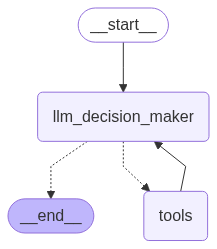

In [27]:
from IPython.display import Image, display
display(Image(ReAct_app.get_graph().draw_mermaid_png()))

In [28]:
config={"configurable": {"thread_id": "1"}}


In [29]:

messages=[HumanMessage(content="give me options for accomodation for dates 3rd August 2025 to 6th August 2025 with 10000 budget in tokyo")]
# messages = ReAct_app.invoke({"messages":messages}, config=config, stream_mode="values")
messages = ReAct_app.invoke({"messages":messages})

LLM response: {'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'gxrvmmakk', 'function': {'arguments': '{"budget":10000,"check_in_date":"2025-08-03","checkout_date":"2025-08-06","destination":"Tokyo"}', 'name': 'accomodation_calculator_tool'}, 'type': 'function'}]}, 'response_metadata': {'token_usage': {'completion_tokens': 364, 'prompt_tokens': 1919, 'total_tokens': 2283, 'completion_time': 1.5656899690000001, 'prompt_time': 0.154005268, 'queue_time': 0.053025341000000004, 'total_time': 1.719695237}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run--d3cb9e61-68cf-4cdd-9bfa-aff76e41fe1d-0', 'example': False, 'tool_calls': [{'name': 'accomodation_calculator_tool', 'args': {'budget': 10000, 'check_in_date': '2025-08-03', 'checkout_date': '2025-08-06', 'destination': 'Tokyo'}, 'id': 'gxrvmmakk', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_meta

In [30]:
for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

give me options for accomodation for dates 3rd August 2025 to 6th August 2025 with 10000 budget in tokyo
================================== Ai Message ==================================
Tool Calls:
  accomodation_calculator_tool (gxrvmmakk)
 Call ID: gxrvmmakk
  Args:
    budget: 10000
    check_in_date: 2025-08-03
    checkout_date: 2025-08-06
    destination: Tokyo
================================= Tool Message =================================
Name: accomodation_calculator_tool

[{"name": "Villa Fontaine Grand Haneda Airport", "price": "US$839", "reviews": "For total 17,052 reviews rating is 8.7 which is Excellent.", "description": "Standard Room, Multiple bed types, Breakfast not included, Non-refunded, See availability"}, {"name": "L stay & grow Minami Sunamachi", "price": "US$424", "reviews": "For total 1,420 reviews rating is 8.7 which is Excellent.", "description": "Standard Room, Multiple bed typ

In [ ]:
messages=[HumanMessage(content="What is current weather and the forecasting in my destination city??")]
# messages = ReAct_app.invoke({"messages":messages}, config=config, stream_mode="values")
messages = ReAct_app.invoke({"messages":messages})

In [ ]:
for message in messages['messages']:
    message.pretty_print()

In [31]:
messages=[HumanMessage(content="which are the best places to visit in Singapore for 7 day trip. What will be estimated budget?")]
# messages = ReAct_app.invoke({"messages":messages}, config=config, stream_mode="values")
messages = ReAct_app.invoke({"messages":messages})

for message in messages['messages']:
    message.pretty_print()

LLM response: {'content': '', 'additional_kwargs': {'tool_calls': [{'id': '5wnncfggk', 'function': {'arguments': '{"destination":"Singapore","duration":7}', 'name': 'itinerary_planner_tool'}, 'type': 'function'}]}, 'response_metadata': {'token_usage': {'completion_tokens': 551, 'prompt_tokens': 1907, 'total_tokens': 2458, 'completion_time': 2.119118904, 'prompt_time': 0.139769552, 'queue_time': 0.05740397800000002, 'total_time': 2.258888456}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run--8a13bf45-4040-4df7-95d4-0a0aa938c36d-0', 'example': False, 'tool_calls': [{'name': 'itinerary_planner_tool', 'args': {'destination': 'Singapore', 'duration': 7}, 'id': '5wnncfggk', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 1907, 'output_tokens': 551, 'total_tokens': 2458}}
LLM response: {'content': '', 'additional_kwargs': {'tool_cal

In [32]:
summary = create_trip_summary(agent_response=messages)

**7-Day Singapore Trip Summary (June 1 - June 7)**

**Itinerary:**

The 7-day itinerary for Singapore includes a mix of cultural exploration, wildlife adventure, and relaxation. Here's a brief overview of each day:

* **Day 1: Arrival in Singapore** - Arrive at Changi Airport, visit Gardens by the Bay, and explore the Marina Bay Sands SkyPark. Enjoy dinner at Newton Food Centre.
* **Day 2: Cultural Exploration** - Explore the National Gallery Singapore, visit the Buddha Tooth Relic Temple, and walk through Chinatown. Dinner at Adam Road Food Centre.
* **Day 3: Wildlife Adventure** - Visit the Singapore Zoo, explore the Night Safari, and have dinner at Haw Par Villa Restaurant.
* **Day 4: Sentosa Island** - Relax at Siloso Beach, visit Universal Studios Singapore, and have dinner at VivoCity Food Court.
* **Day 5: Food and Neighborhoods** - Explore Tiong Bahru Market, visit Little India Arcade, and have dinner at Adam Road Food Centre.
* **Day 6: Nature Escapes** - Hike at MacRitchie Re

In [34]:
messages=[HumanMessage(content="I want to plan a 7 days trip to Hawai islands with budget of 750000 Indian Rupees for 2 people. Give me proper trip plan including famouse locations, activitioes, restaurant, budget friendly hotel stay. Also give me current weather")]
# messages = ReAct_app.invoke({"messages":messages}, config=config, stream_mode="values")
messages = ReAct_app.invoke({"messages":messages})

for message in messages['messages']:
    message.pretty_print()

LLM response: {'content': '', 'additional_kwargs': {'tool_calls': [{'id': '8yg8v2d13', 'function': {'arguments': '{"destination":"Hawaiian Islands","duration":7}', 'name': 'itinerary_planner_tool'}, 'type': 'function'}]}, 'response_metadata': {'token_usage': {'completion_tokens': 702, 'prompt_tokens': 1939, 'total_tokens': 2641, 'completion_time': 2.552727273, 'prompt_time': 0.141939348, 'queue_time': 0.05562251300000001, 'total_time': 2.694666621}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run--37b99ce0-0833-4c2e-8422-17ce3b9f979d-0', 'example': False, 'tool_calls': [{'name': 'itinerary_planner_tool', 'args': {'destination': 'Hawaiian Islands', 'duration': 7}, 'id': '8yg8v2d13', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 1939, 'output_tokens': 702, 'total_tokens': 2641}}
LLM response: {'content': '', 'additional_kwarg

In [35]:
summary = create_trip_summary(agent_response=messages)

**7-Day Hawaiian Islands Trip Summary (June 18 - June 25)**

**Destination:** Hawaiian Islands, USA
**Duration:** 7 days
**Start Date:** June 18
**End Date:** June 25

**Itinerary:**

* **Day 1-2: Arrival in Honolulu, Oahu**
	+ Arrive at Honolulu International Airport
	+ Check-in at a budget-friendly hotel in Waikiki Beach, such as the Moana Surfrider
	+ Visit iconic Waikiki Beach and take a stroll along the Waikiki Beach Walk
	+ Enjoy a traditional Hawaiian dinner at Alan Wong's Honolulu
* **Day 3: Pearl Harbor and USS Arizona Memorial**
	+ Take a short drive to Pearl Harbor
	+ Visit the USS Arizona Memorial and take a boat tour of the USS Missouri and USS Oklahoma Memorials
* **Day 4: Fly to Kauai**
	+ Fly from Honolulu International Airport to Lihue Airport
	+ Check-in at a budget-friendly hotel in Poipu, such as the Grand Hyatt Kauai Resort and Spa
	+ Visit the Spouting Horn and explore the scenic Poipu Beach
* **Day 5: Na Pali Coast and Wailua River**
	+ Take a guided boat tour of